# ABRAÇOS AI acoustic data exploration

## 1. netCDF echointegrated acoustic data

Two echointegration resolutions are available in netCDF format following the ICES guidelines:
* Low resolution (1 file) - 0.1 nmi x 5 m
* High resolution (2 file, one for each leg) - 3 pings x 1 m

We will investigate the high resolution files, more suited to the final task.

In [3]:
# Indicate file paths and assert file existence
import os
from pathlib import Path

raw_data_path = Path("../data/raw/")
raw_acoustic_A1_path = raw_data_path / "acoustic-data/netCDF-echointegrations/Abracos_A1/high-res/"

leg1_path = raw_acoustic_A1_path / "LEG01/IRD_SOOP-BA_A_20150929T192933Z_ANTEA_FV02_ABRACOS-38-70-120-200_END-20151021T190616Z_C.nc"
leg2_path = raw_acoustic_A1_path / "LEG02/IRD_SOOP-BA_A_20150929T192933Z_ANTEA_FV02_ABRACOS-38-70-120-200_END-20151021T190616Z.nc"

assert os.path.isfile(leg1_path), "LEG1 file not found."
assert os.path.isfile(leg2_path), "LEG2 file not found."

## 2. Opening as `netCDF4.Dataset` and extracting metada

In [4]:
import netCDF4 as nc

ds_leg1 = nc.Dataset(leg1_path)
ds_leg2 = nc.Dataset(leg2_path)

def print_file_infos(ds: nc.Dataset):
    # Name of the cruise
    print(f"* Title:\t{ds.title}")

    # Time period of sampling
    time_var = ds.variables["time"]
    time_dates = nc.num2date(
        time_var[:],
        units=time_var.units,
        calendar=time_var.calendar,
        only_use_cftime_datetimes=True
    )
    start = time_dates[0].strftime('%d %b %Y, %H:%M')
    end = time_dates[-1].strftime('%d %b %Y, %H:%M')
    tz = "UTC" # num2date standard
    
    print(f"* Dates:\t{str(start)} - {end} ({tz})")
    
    print(f"* Resolution:\t{ds.data_ping_axis_interval_value} {ds.data_ping_axis_interval_type} x {ds.data_range_axis_interval_value} {ds.data_range_axis_interval_type}")
    print(f"* Dimensions:\t({ds.dimensions['time'].size}, {ds.dimensions['depth'].size}, {ds.dimensions['channel'].size}) - ({ds.dimensions['time'].name}, {ds.dimensions['depth'].name}, {ds.dimensions['channel'].name})")
    print(f"* N pixels:\t{ds.dimensions['time'].size * ds.dimensions['depth'].size}")


print("High resolution file 1 (LEG 1):")
print_file_infos(ds_leg1)
print()
print("High resolution file 2 (LEG 2):")
print_file_infos(ds_leg2)
print()

n_pixels = ds_leg1.dimensions['time'].size * ds_leg1.dimensions['depth'].size + ds_leg2.dimensions['time'].size * ds_leg2.dimensions['depth'].size

print(f"Total N pixels high resolution: {n_pixels}")

High resolution file 1 (LEG 1):
* Title:	Acoustic along the BRAzilian COaSt in October 2015
* Dates:	29 Sep 2015, 19:29 - 09 Oct 2015, 19:14 (UTC)
* Resolution:	3.0 Number of pings x 1.0 Range (meters)
* Dimensions:	(129422, 745, 4) - (time, depth, channel)
* N pixels:	96419390

High resolution file 2 (LEG 2):
* Title:	Acoustic along the BRAzilian COaSt in October 2015
* Dates:	11 Oct 2015, 10:30 - 21 Oct 2015, 19:06 (UTC)
* Resolution:	3.0 Number of pings x 1.0 Range (meters)
* Dimensions:	(286431, 745, 4) - (time, depth, channel)
* N pixels:	213391095

Total N pixels high resolution: 309810485
* Dates:	11 Oct 2015, 10:30 - 21 Oct 2015, 19:06 (UTC)
* Resolution:	3.0 Number of pings x 1.0 Range (meters)
* Dimensions:	(286431, 745, 4) - (time, depth, channel)
* N pixels:	213391095

Total N pixels high resolution: 309810485


## 3. Opening using `xarray` (LEG 1 only for now)

In [5]:
import xarray as xr

leg1 = xr.open_dataset(leg1_path)
leg2 = xr.open_dataset(leg2_path)

# Add a 'leg' variable to each dataset
leg1 = leg1.assign_coords(leg=(('time',), [1]*leg1.sizes['time']))
leg2 = leg2.assign_coords(leg=(('time',), [2]*leg2.sizes['time']))

# Concatenate and sort by time to ensure order
combined = xr.concat([leg1, leg2], dim='time', data_vars='all')
if 'time' in combined:
    ds = combined.sortby('time')
else:
    ds = combined

print(ds)


<xarray.Dataset> Size: 11GB
Dimensions:                                 (channel: 4, time: 415853,
                                             depth: 745, STRING4_1: 4,
                                             STRING6_2: 6, STRING11_3: 11,
                                             STRING27_4: 27, STRING17_5: 17,
                                             STRING6_6: 6, STRING4_7: 4,
                                             STRING22_8: 22, STRING15_9: 15,
                                             STRING23_10: 23, STRING42_11: 42,
                                             STRING97_12: 97, STRING2_13: 2)
Coordinates:
  * channel                                 (channel) float64 32B 38.0 ... 200.0
  * time                                    (time) datetime64[ns] 3MB 2015-09...
  * depth                                   (depth) float64 6kB 7.5 ... 751.5
    latitude                                (time) float64 3MB -5.514 ... -8.057
    longitude                         

In [6]:
n_pixels_combined = ds.sizes['time'] * ds.sizes['depth']
n_pixels_combined == n_pixels

True

# Survey map

Let's try to map the whole survey using the `latitude`, `longitude` and `time` variables.

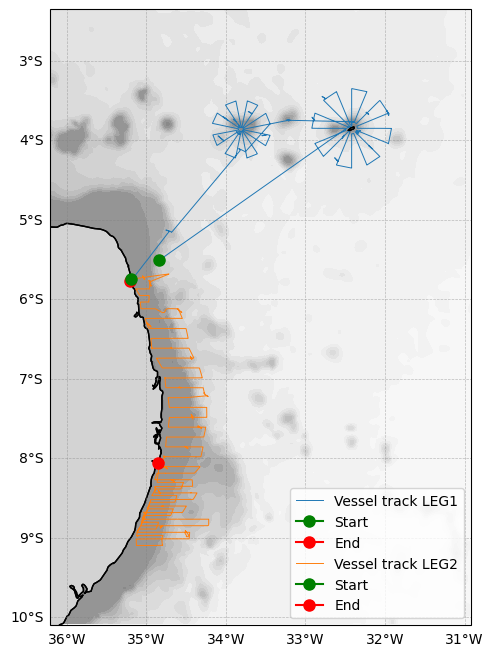

In [7]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Assume leg1_xr is your Dataset
lats = ds['latitude'].values
lons = ds['longitude'].values
legs = ds['leg'].values

# Create figure and axis with a PlateCarree projection
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Using NOAA ETOPO1 data
# Download: https://www.ngdc.noaa.gov/mgg/global/relief/ETOPO1/data/bedrock/grid_registered/netcdf/
etopo = xr.open_dataset("../data/external/spatial/bathymetry/ETOPO1_Bed_g_gmt4.grd")  # replace with your path
bathy = etopo['z']

# Subset bathymetry to your region
bathy_region = bathy.sel(x=slice(lons.min()-1, lons.max()+1),
                         y=slice(lats.min()-1, lats.max()+1))

# Plot bathymetry
ax.contourf(
    bathy_region['x'], bathy_region['y'], bathy_region,
    levels=np.arange(-6000, 6000, 500),
    cmap='Grays', transform=ccrs.PlateCarree()
)

# Add land and coastlines
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.COASTLINE)

# Optionally add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Plot vessel tracks grouped by leg
for leg_num in np.unique(legs):
    mask = legs == leg_num
    ax.plot(
        lons[mask], lats[mask],
        label=f'Vessel track LEG{leg_num}',
        linewidth=0.7,
        transform=ccrs.PlateCarree()
    )
    # Optionally plot start and end points for each leg
    ax.plot(lons[mask][0], lats[mask][0], marker='o', color='green', markersize=8, label='Start', transform=ccrs.PlateCarree())
    ax.plot(lons[mask][-1], lats[mask][-1], marker='o', color='red', markersize=8, label='End', transform=ccrs.PlateCarree())

# Set map extent around the vessel track
margin = 1.0  # degrees
ax.set_extent([lons.min()-margin, lons.max()+margin, lats.min()-margin, lats.max()+margin])

# Add title and legend
plt.title('')
plt.legend()
plt.show()

# Acoustic data overview

In [8]:
sv = ds['Sv']
print(sv) # Adjust variable name as needed

<xarray.DataArray 'Sv' (channel: 4, time: 415853, depth: 745)> Size: 5GB
array([[[-150.      , -150.      , -150.      , ...,         nan,
                 nan,         nan],
        [-150.      , -150.      , -150.      , ..., -150.      ,
                 nan,         nan],
        [-150.      , -150.      ,  -94.177055, ...,  -83.59829 ,
                 nan,         nan],
        ...,
        [-150.      , -150.      ,  -48.048996, ...,         nan,
                 nan,         nan],
        [-150.      , -150.      ,  -71.769554, ...,         nan,
                 nan,         nan],
        [-150.      , -150.      , -150.      , ...,         nan,
                 nan,         nan]],

       [[-150.      , -150.      , -150.      , ...,         nan,
                 nan,         nan],
        [-150.      , -150.      ,  -99.855965, ...,         nan,
                 nan,         nan],
        [-150.      , -150.      ,  -84.10026 , ...,         nan,
                 nan,         

## 1. Plot all Sv channels as facets

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

def plot_sv_channels_faceted(
    sv: xr.DataArray,
    outfile: str = "Sv_all_channels_faceted.png",
    cmap: str = "viridis",
    figsize: tuple = (20, 12),
    vmin: float | None = None,
    vmax: float | None = None,
    sample_pixels: int | None = 2_000_000,
):
    """
    Plot all Sv channels as facets (subplots) with a single shared colorbar.
    Efficient for very large xarray DataArrays by subsampling.

    Parameters
    ----------
    sv : xarray.DataArray
        The Sv DataArray with dims (channel, time, depth).
    outfile : str
        Path to save the output figure (PNG).
    cmap : str
        Matplotlib colormap.
    figsize : tuple
        Size of the full figure (width, height).
    vmin, vmax : float or None
        Optional fixed colorbar limits (in dB).
    sample_pixels : int or None
        If set, subsample the data to have at most this many pixels per channel for plotting and color scaling.
    """
    n_channels = sv.sizes["channel"]
    fig, axes = plt.subplots(
        n_channels, 1,
        figsize=figsize,
        constrained_layout=True,
        sharex=True
    )
    if n_channels == 1:
        axes = [axes]

    # Subsampling for efficiency
    time_dim = sv.sizes["time"]
    depth_dim = sv.sizes["depth"]
    max_pixels = sample_pixels if sample_pixels is not None else time_dim * depth_dim
    stride_t = max(1, int(np.ceil(np.sqrt((time_dim * depth_dim) / max_pixels))))
    stride_d = stride_t

    print(f"Subsampling for plotting: every {stride_t} time steps and every {stride_d} depth levels.")

    # Use a small chunk for vmin/vmax calculation
    if vmin is None or vmax is None:
        sv_sample = sv.isel(
            time=slice(0, time_dim, stride_t),
            depth=slice(0, depth_dim, stride_d)
        ).values
        if vmin is None:
            vmin = float(np.nanpercentile(sv_sample, 2))
        if vmax is None:
            vmax = float(np.nanpercentile(sv_sample, 98))

    imgs = []
    for i, ax in enumerate(axes):
        freq = sv.channel.values[i]
        sv_ch = sv.isel(channel=i)
        # Subsample for plotting
        sv_ch_plot = sv_ch.isel(
            time=slice(0, time_dim, stride_t),
            depth=slice(0, depth_dim, stride_d)
        )
        img = ax.pcolormesh(
            sv_ch_plot["time"].values,
            sv_ch_plot["depth"].values,
            sv_ch_plot.T.values,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax
        )
        ax.invert_yaxis()
        ax.set_title(f"Channel {freq:.0f} kHz", fontsize=12)
        ax.set_ylabel("Depth (m)")
        imgs.append(img)

    axes[-1].set_xlabel("Time (UTC)")

    # Add a single colorbar for all subplots
    cbar = fig.colorbar(imgs[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
    cbar.set_label("Sv (dB)")

    plt.savefig(outfile, dpi=300)
    plt.close(fig)
    print(f"\nFigure saved as '{outfile}'")


Subsampling for plotting: every 6 time steps and every 6 depth levels.

Figure saved as 'output/figures/Sv_all_channels_faceted_clipped.png'

Figure saved as 'output/figures/Sv_all_channels_faceted_clipped.png'


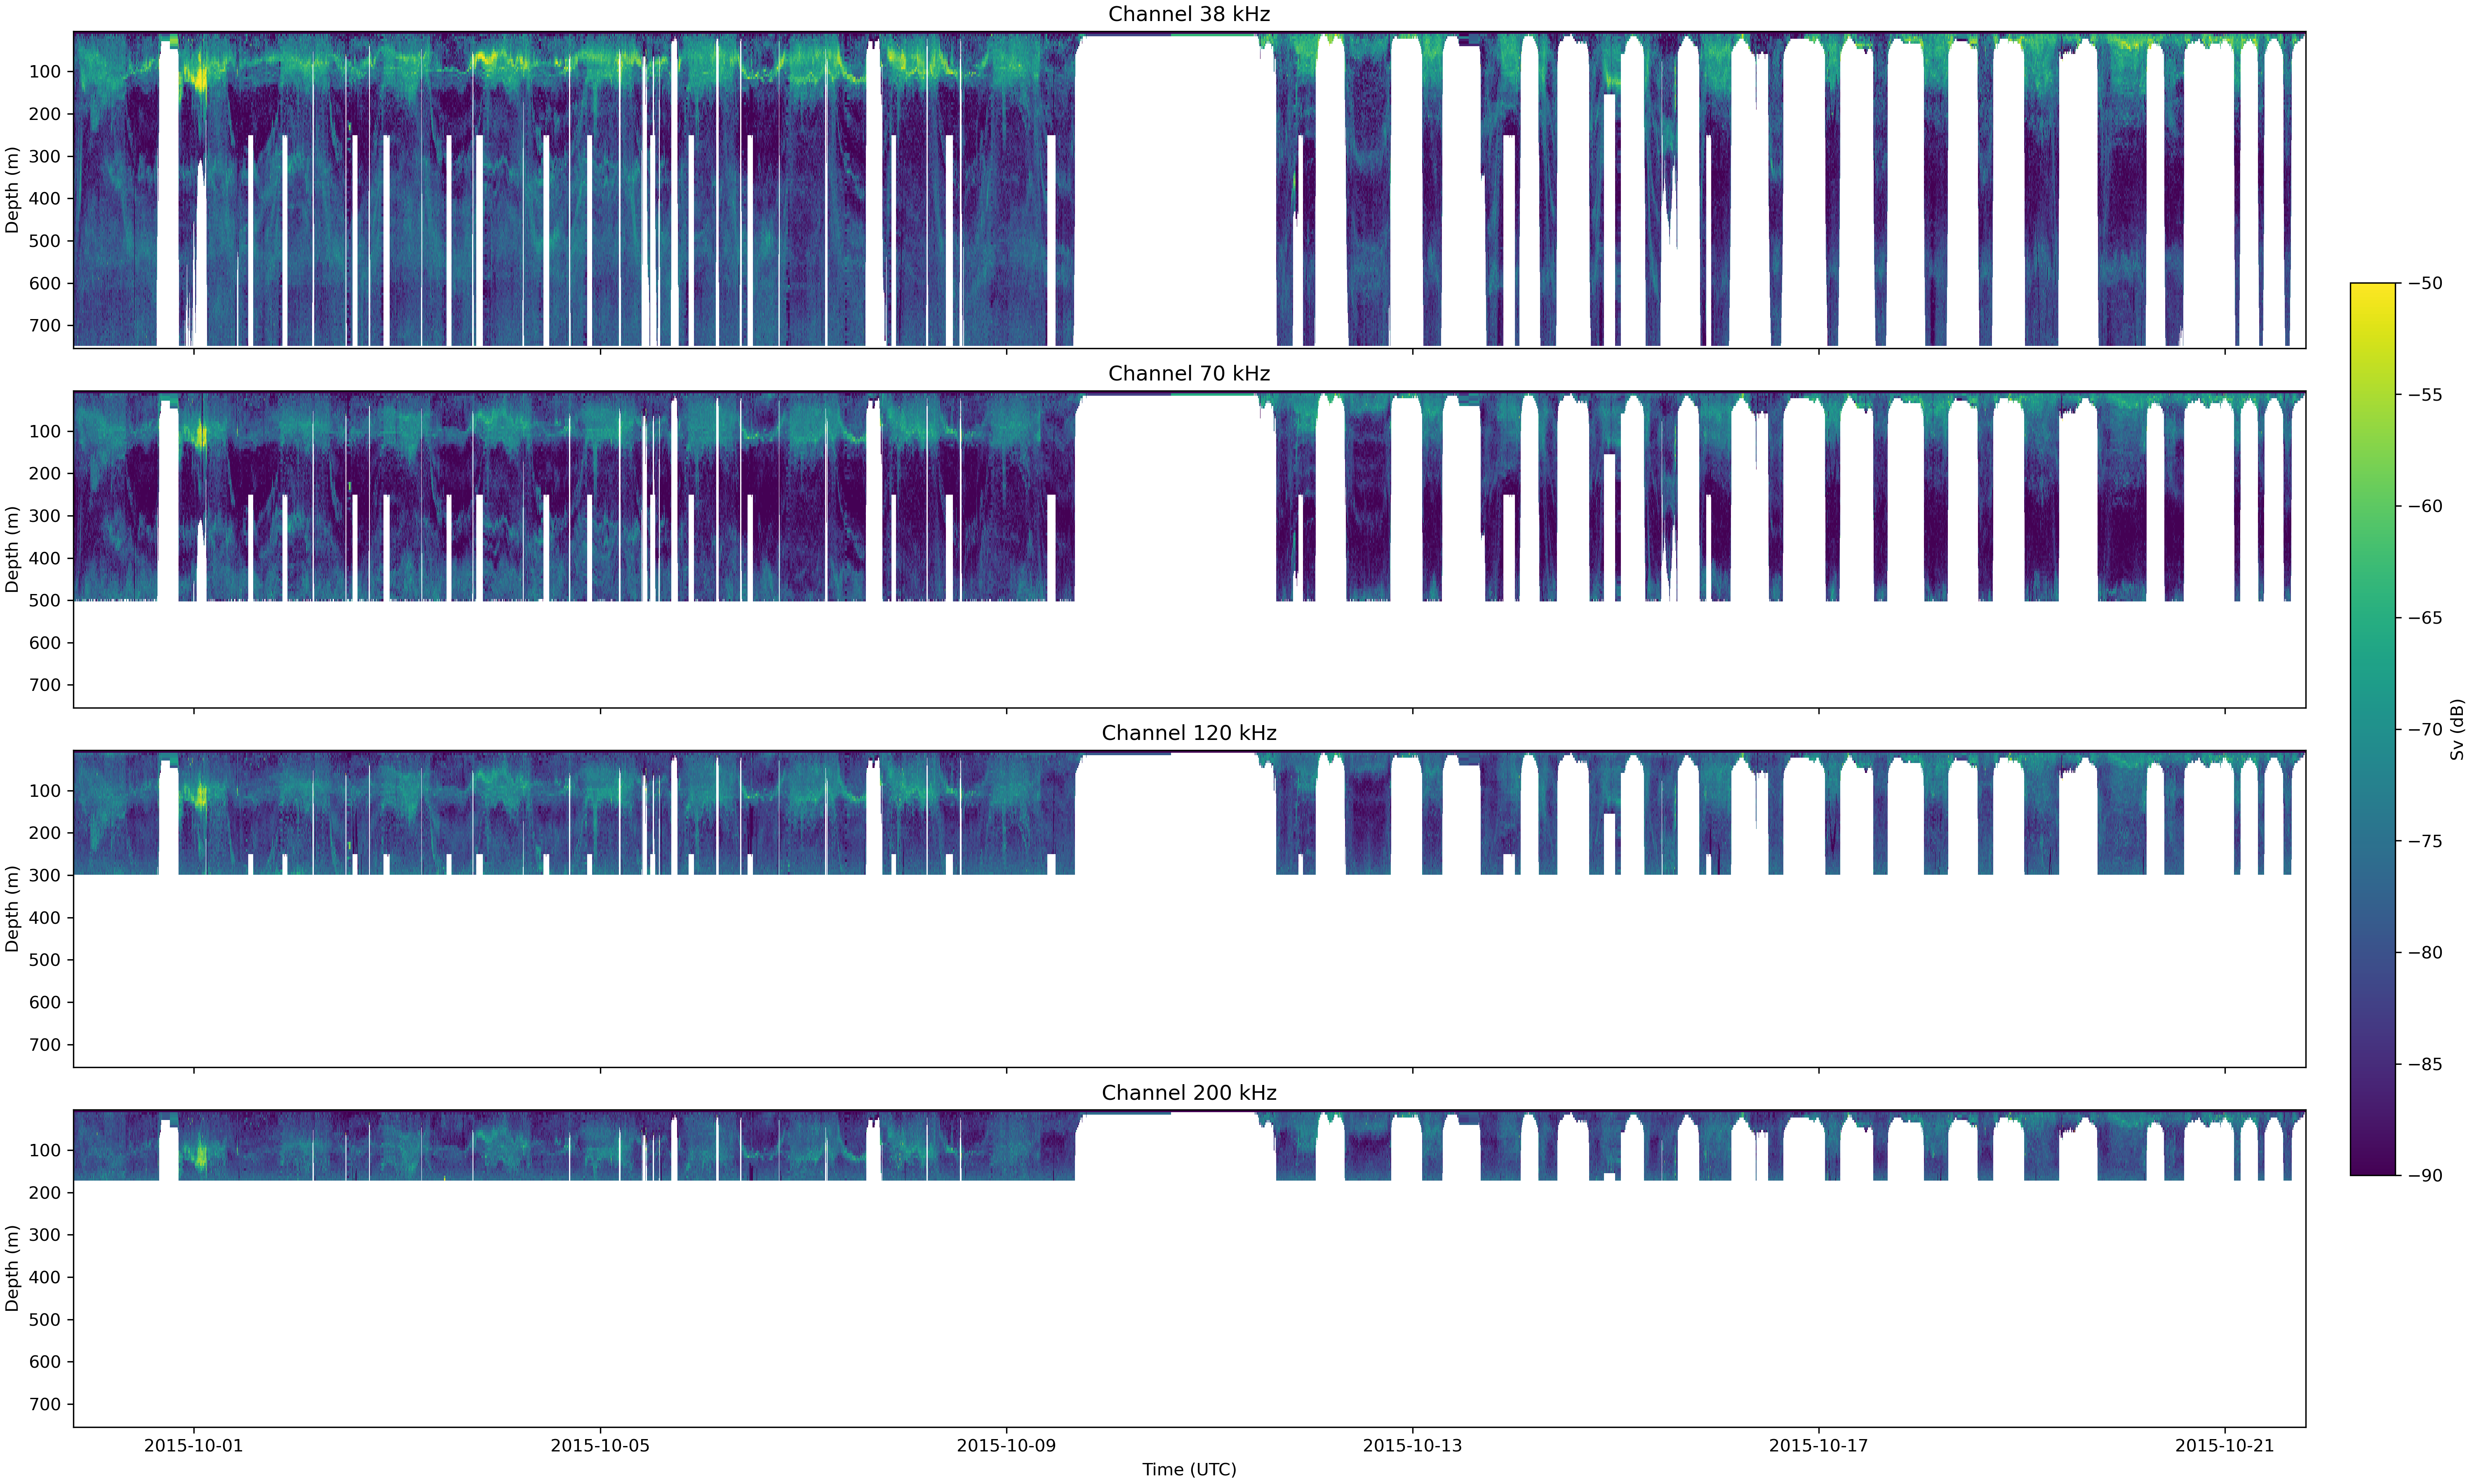

In [18]:
from PIL import Image

if not os.path.isfile("output/figures/Sv_all_channels_faceted_clipped.png"):
    plot_sv_channels_faceted(
        sv,
        outfile="output/figures/Sv_all_channels_faceted_clipped.png",
        cmap="viridis",
        figsize=(20, 12),
        vmin=-90,
        vmax=-50,
        sample_pixels=10_000_000
    )
img = Image.open("output/figures/Sv_all_channels_faceted_clipped.png")
img

# Plot 38, 70 and 120 kHz as RGB image

In [ ]:
def plot_sv_rgb(
    sv: xr.DataArray,
    outfile: str = "Sv_RGB_38_70_120kHz.png",
    figsize: tuple = (18, 8),
    vmin: float = -90,
    vmax: float = -50,
    time_slice: slice = slice(None),
    depth_slice: slice = slice(None),
):
    """
    Plot Sv as an RGB image using 38 kHz (R), 70 kHz (G), 120 kHz (B) channels.

    Parameters
    ----------
    sv : xarray.DataArray
        The Sv DataArray with dims (channel, time, depth).
    outfile : str
        Path to save the output figure (PNG).
    figsize : tuple
        Size of the figure (width, height).
    vmin, vmax : float
        Color scale limits (in dB).
    time_slice, depth_slice : slice
        Slices for time and depth dimensions.
    """
    import matplotlib.pyplot as plt

    # Channel frequencies for RGB
    rgb_freqs = [38, 70, 120]
    rgb_idx = []
    for f in rgb_freqs:
        idx = np.where(np.isclose(sv.channel.values, f))[0]
        if len(idx) == 0:
            raise ValueError(f"Channel {f} kHz not found in sv.channel.")
        rgb_idx.append(idx[0])

    # Select and normalize Sv for each channel
    sv_rgb = []
    for i in rgb_idx:
        arr = sv.isel(channel=i, time=time_slice, depth=depth_slice).T.values
        arr = np.clip((arr - vmin) / (vmax - vmin), 0, 1)
        arr = np.nan_to_num(arr, nan=0.0)
        sv_rgb.append(arr)
    # Stack to (depth, time, 3)
    rgb_img = np.stack(sv_rgb, axis=-1)

    # Prepare axes for plotting (like plot_sv_channels_faceted)
    time_vals = sv["time"].values[time_slice]
    depth_vals = sv["depth"].values[depth_slice]

    fig, ax = plt.subplots(figsize=figsize)
    img = ax.imshow(
        rgb_img,
        aspect="auto",
        origin="lower",
        extent=[
            time_vals[0], time_vals[-1],
            depth_vals[0], depth_vals[-1]
        ]
    )
    ax.invert_yaxis()
    ax.set_xlabel("Time (UTC)")
    ax.set_ylabel("Depth (m)")
    ax.set_title("Sv RGB composite: R=38kHz, G=70kHz, B=120kHz")
    plt.savefig(outfile, dpi=300, bbox_inches="tight")
    plt.close(fig)
    print(f"RGB Sv image saved as '{outfile}'")

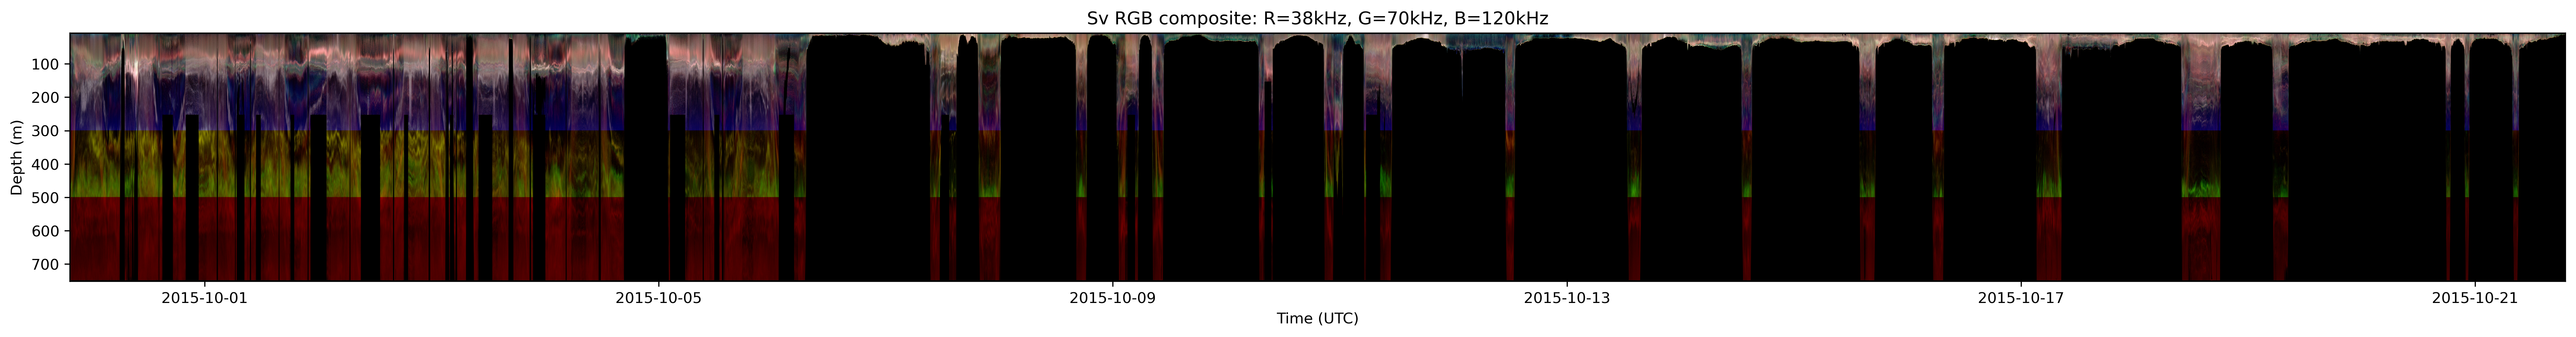

In [ ]:
if not os.path.isfile("output/figures/Sv_RGB_38_70_120kHz.png"):
    plot_sv_rgb(
        sv,
        outfile="output/figures/Sv_RGB_38_70_120kHz.png",
        cmap="viridis",
        figsize=(30, 3),
        vmin=-90,
        vmax=-50
    )
img = Image.open("output/figures/Sv_RGB_38_70_120kHz.png")
img